In [1]:
import numpy as np
import os, sys, string
import cv2
from src.network.models import Puigcerver_supervised
from src.data.tokenizer import Tokenizer
import torch
from torchvision import transforms
import editdistance
sys.path.append("./")
sys.path.append("./src/network")
sys.path.append("./src")
from src.network.gen_model.gen_model import GenModel_FC
from src.data.data_loader import RIMES_data

In [2]:
charset_base = string.ascii_lowercase + string.ascii_uppercase
    
tokenizer = Tokenizer(chars=charset_base, max_text_length=25, self_supervised=False)
transforms_ = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])

In [4]:
supervised_htr = Puigcerver_supervised(input_size = (64, 216, 1), d_model=57)
supervised_htr.load_state_dict(torch.load("./src/network/htr_model_supervised-60.model")) #load
supervised_htr.eval()

(64, 216, 1) 57


Puigcerver_supervised(
  (cnn): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (8): Dropout(p=0.2, inplace=False)
    (9): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
    (10): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.01)
    (12): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mod

In [5]:
cer = 0
self_htr_data_file = "./data/iam/words/ground_truth_train_filtered.txt"
img_paths_100 = []
wids_100 = []
words_100 = []

upper_mean_bound = -0.6
lower_mean_bound = -1.0

with open(self_htr_data_file, 'r') as f:
    lines = f.read().splitlines()

for line in lines:
    line_split = line.split(' ')
    wid = None

    if not set(string.digits).isdisjoint(set(line_split[-1])):
        wid = line_split[-1]
        line_split = line_split[:-1]
        
    if len(line_split) > 2:
        img_path, gt_label = line_split[0], ''.join(line_split[1:])
    else:
        img_path, gt_label = line_split[0], line_split[1]
        
    img_path = img_path.replace("/", "\\")[1:]

    img = 255 - cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
    img = transforms_(img)
    img_mean = torch.mean(img)

    if img_mean <= upper_mean_bound and img_mean >= lower_mean_bound:


        # label = tokenizer.encode(label)
        y_pred = supervised_htr(img.unsqueeze(0))

        y_pred_soft = torch.nn.functional.softmax(y_pred, dim=2).detach().cpu()
        y_pred_max = torch.max(y_pred_soft, dim=2).indices
        y_pred = [tokenizer.decode(label) for label in y_pred_max]

        if y_pred[0] == gt_label:
            print(y_pred, gt_label)
            img_paths_100.append((img_path, gt_label, wid))
            wids_100.append(wid)
            words_100.append(gt_label)
            # print(words_100)

print(len(img_paths_100))


['in'] in
['the'] the
['that'] that
['their'] their
['stock'] stock
['has'] has
['the'] the
['of'] of
['and'] and
['an'] an
['on'] on
['or'] or
['to'] to
['The'] The
['is'] is
['that'] that
['could'] could
['have'] have
['been'] been
['for'] for
['in'] in
['the'] the
['and'] and
['in'] in
['in'] in
['the'] the
['the'] the
['into'] into
['the'] the
['to'] to
['see'] see
['that'] that
['was'] was
['the'] the
['she'] she
['that'] that
['there'] there
['was'] was
['no'] no
['of'] of
['out'] out
['and'] and
['the'] the
['his'] his
['and'] and
['good'] good
['then'] then
['in'] in
['the'] the
['of'] of
['the'] the
['of'] of
['the'] the
['been'] been
['on'] on
['the'] the
['of'] of
['the'] the
['on'] on
['it'] it
['much'] much
['the'] the
['They'] They
['will'] will
['and'] and
['will'] will
['have'] have
['to'] to
['The'] The
['to'] to
['the'] the
['and'] and
['in'] in
['They'] They
['It'] It
['is'] is
['to'] to
['the'] the
['of'] of
['no'] no
['with'] with
['is'] is
['of'] of
['in'] in
['by

In [12]:
img_paths_100_max4char = []
wids_100_4maxchar = []
words_100_4maxchar = []
wid_dict = {}

for tup in img_paths_100:
    if len(tup[1]) <= 4:
        img_paths_100_max4char.append(tup)
        wids_100_4maxchar.append(tup[2])
        words_100_4maxchar.append(tup[1])
        if tup[2] in wid_dict.keys():
            wid_dict[tup[2]] += 1
        else:
            wid_dict[tup[2]] = 1


print("number of samples with 4 characters of less: ", len(img_paths_100_max4char))
print("number of unique writers: ", len(set(wids_100_4maxchar)))
print("number of unique words: ", len(set(words_100_4maxchar)))

wid_dict = sorted(wid_dict.items(), key=lambda x:x[1], reverse=True)
wid_dict = dict(wid_dict)

filtered_wids = {}

for wid in wid_dict:
    if wid_dict[wid] >= 25:
        filtered_wids[wid] = [wid_dict[wid]]

print("number of unique writers with 25 or more samples:", len(filtered_wids.keys()))

img_paths_filtered = []
wids_filtered = []
words_filtered = []
for tup in img_paths_100_max4char:
    if tup[2] in filtered_wids.keys():
        img_paths_filtered.append(tup)
        wids_filtered.append(tup[2])
        words_filtered.append(tup[1])
        filtered_wids[tup[2]].append(tup[0])

print()
print("Number of samples:", len(img_paths_filtered))
print("Number of unique writers:", len(set(wids_filtered)))
print("Number of unique words:", len(set(words_filtered)))

for wid in set(wids_filtered):
    print(wid)
    # print(filtered_wids[wid][1])

for id in wid_dict.keys():
    print(id, wid_dict[id])

number of samples with 4 characters of less:  7691
number of unique writers:  497
number of unique words:  189
number of unique writers with 25 or more samples: 84

Number of samples: 3882
Number of unique writers: 84
Number of unique words: 148
132
287
587
150
635
193
549
273
131
582
585
340
344
155
333
243
113
125
124
206
285
546
337
059
204
026
085
291
289
293
246
342
064
544
118
670
094
551
128
203
151
109
130
315
241
247
338
274
060
133
199
634
552
152
336
334
339
248
341
110
202
126
586
671
205
209
343
117
154
588
288
583
037
153
000
332
335
547
207
292
567
025
174
173
000 335
152 83
551 80
340 79
344 75
671 74
339 72
336 72
343 71
150 71
154 70
335 69
552 68
333 67
334 67
153 66
342 63
151 63
670 62
155 62
341 61
332 60
635 60
338 59
337 58
209 57
274 49
588 49
634 46
288 44
248 43
207 41
126 39
587 39
203 39
206 38
085 37
118 37
174 37
205 37
582 36
202 36
064 35
585 35
125 34
549 34
292 34
289 33
315 33
128 32
059 32
025 31
133 31
204 31
117 30
037 30
109 29
273 29
246 28
113 

085
.\data\iam\words\train\a06\a06-157\a06-157-00-03.png


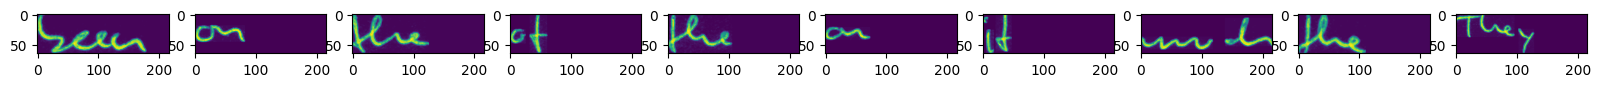

334
.\data\iam\words\train\g06\g06-047c\g06-047c-00-03.png


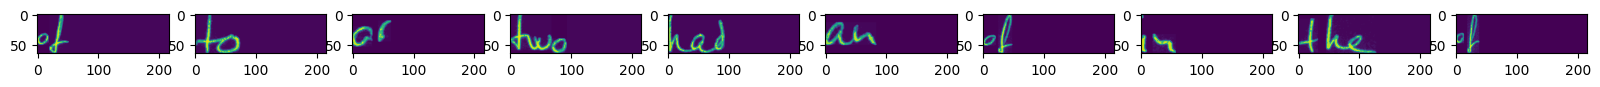

246
.\data\iam\words\train\e07\e07-061\e07-061-06-01.png


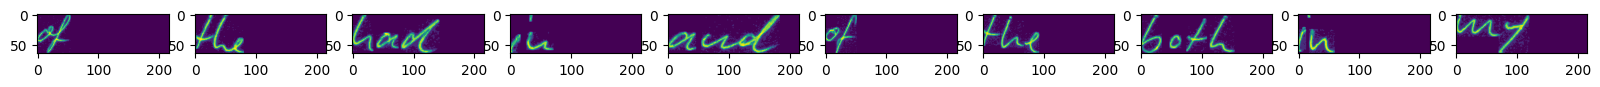

152
.\data\iam\words\train\c03\c03-087c\c03-087c-03-00.png


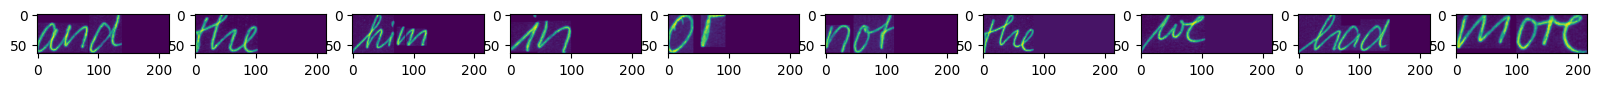

547
.\data\iam\words\train\m04\m04-131\m04-131-01-00.png


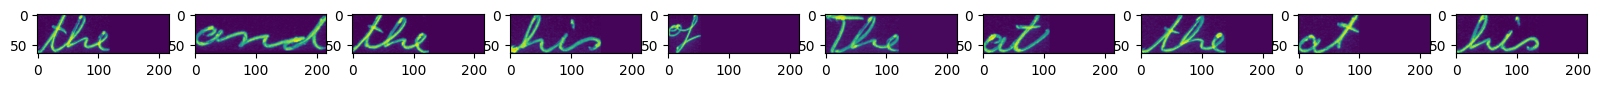

567
.\data\iam\words\train\p03\p03-096\p03-096-08-05.png


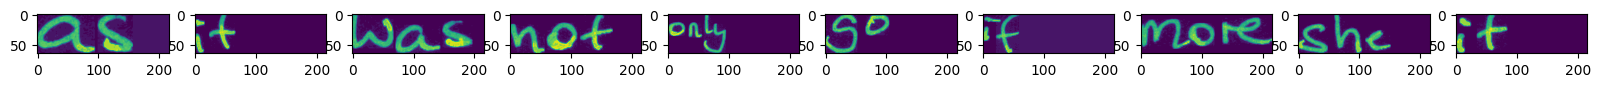

207
.\data\iam\words\train\e06\e06-033\e06-033-05-05.png


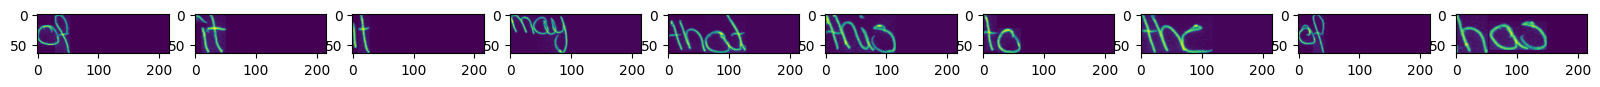

248
.\data\iam\words\train\e07\e07-101\e07-101-05-02.png


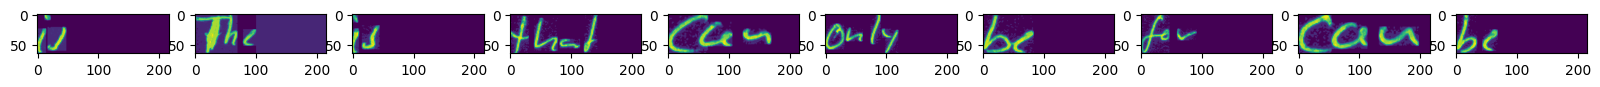

342
.\data\iam\words\train\g06\g06-018k\g06-018k-05-09.png


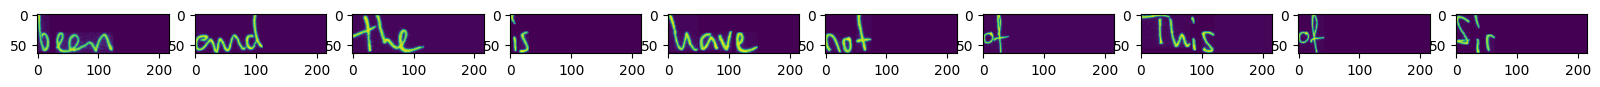

205
.\data\iam\words\train\e06\e06-026\e06-026-02-04.png


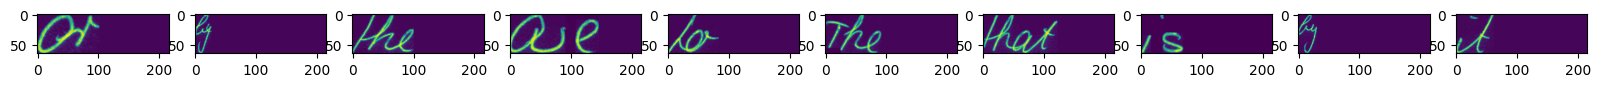

273
.\data\iam\words\train\g04\g04-014\g04-014-02-05.png


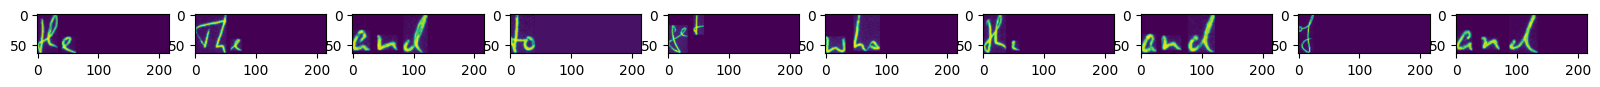

344
.\data\iam\words\train\g06\g06-037m\g06-037m-03-08.png


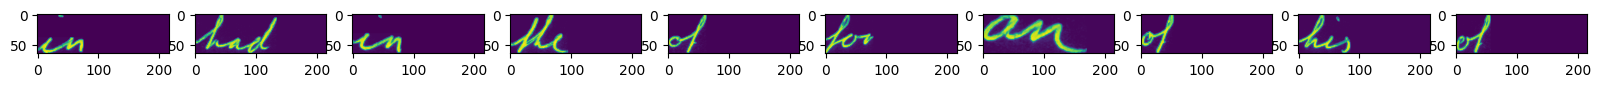

247
.\data\iam\words\train\e07\e07-090\e07-090-04-01.png


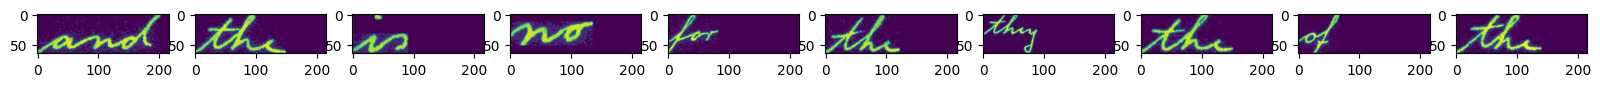

064
.\data\iam\words\train\a04\a04-099\a04-099-08-06.png


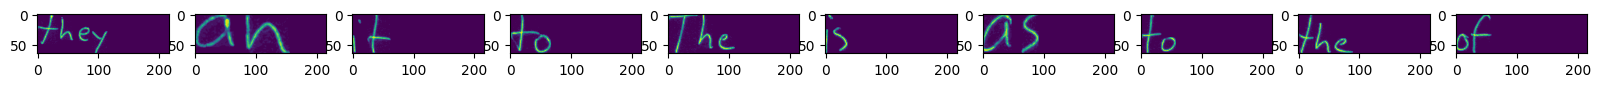

544
.\data\iam\words\train\m04\m04-019\m04-019-02-10.png


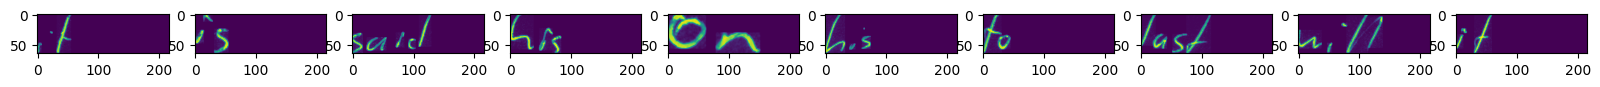

288
.\data\iam\words\train\f07\f07-028a\f07-028a-04-05.png


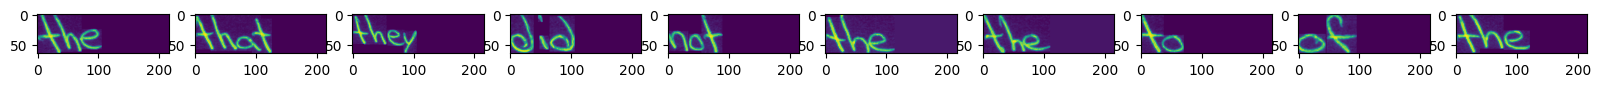

274
.\data\iam\words\train\h04\h04-025\h04-025-00-11.png


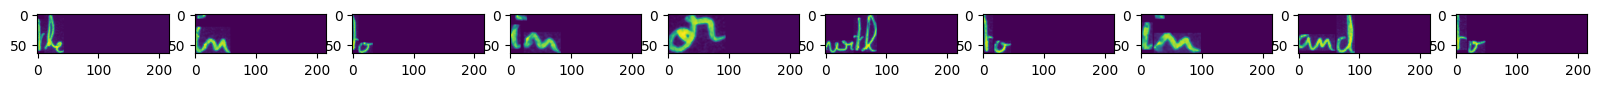

332
.\data\iam\words\train\g06\g06-050a\g06-050a-01-08.png


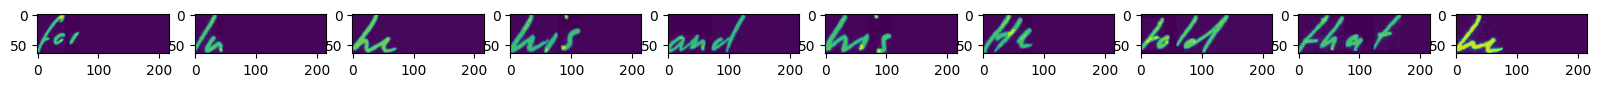

336
.\data\iam\words\train\g06\g06-050e\g06-050e-01-06.png


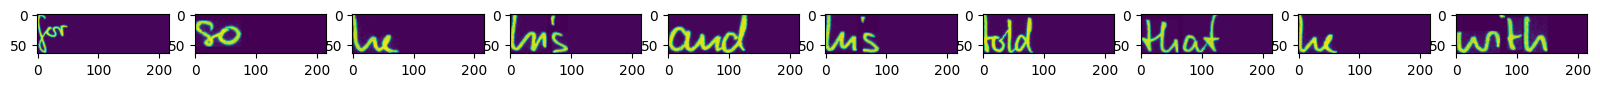

150
.\data\iam\words\train\c03\c03-021a\c03-021a-09-00.png


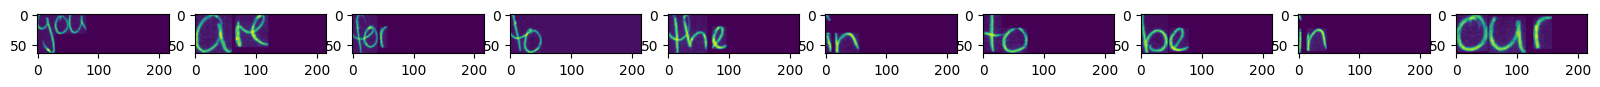

209
.\data\iam\words\train\d07\d07-096\d07-096-05-08.png


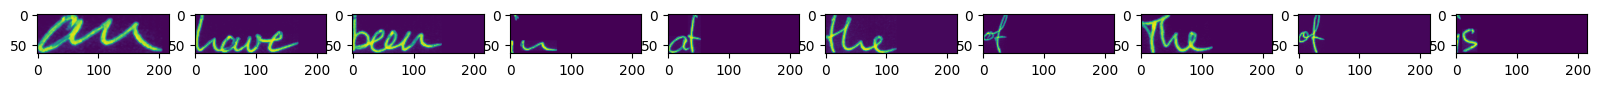

117
.\data\iam\words\train\b05\b05-038\b05-038-07-07.png


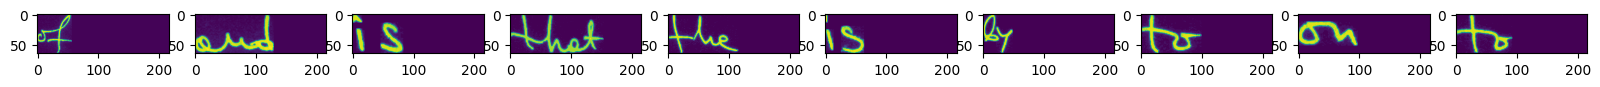

202
.\data\iam\words\train\e06\e06-037\e06-037-02-05.png


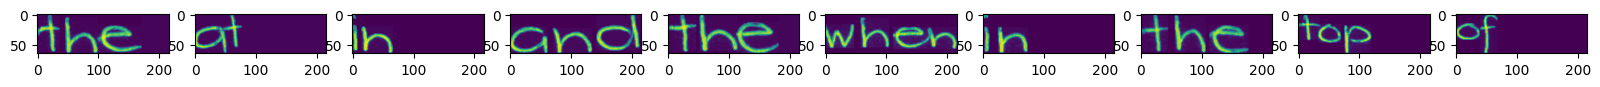

343
.\data\iam\words\train\g06\g06-026l\g06-026l-01-09.png


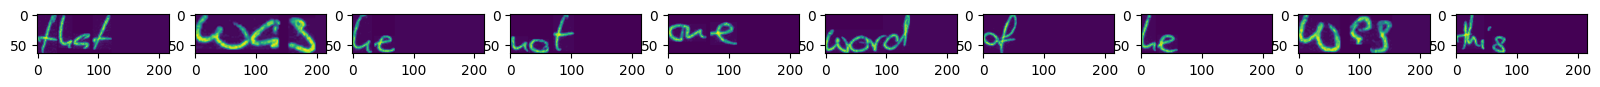

292
.\data\iam\words\train\f07\f07-088a\f07-088a-04-04.png


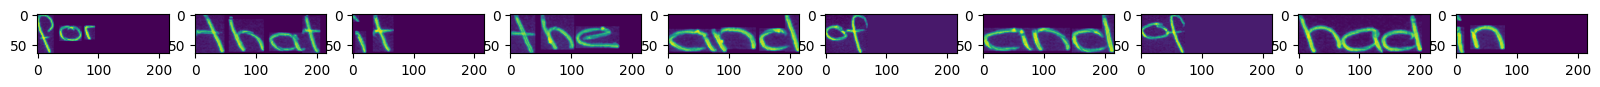

635
.\data\iam\words\train\r06\r06-018\r06-018-05-03.png


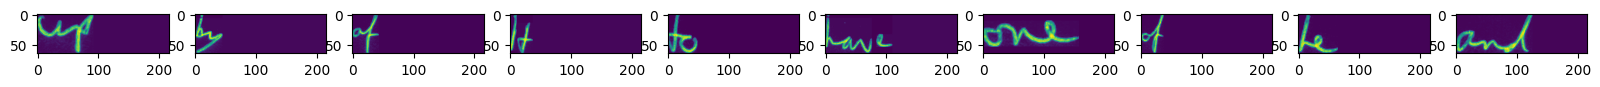

174
.\data\iam\words\train\d06\d06-050\d06-050-02-09.png


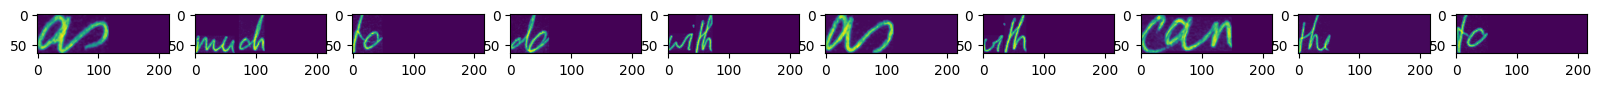

552
.\data\iam\words\train\m06\m06-083\m06-083-06-08.png


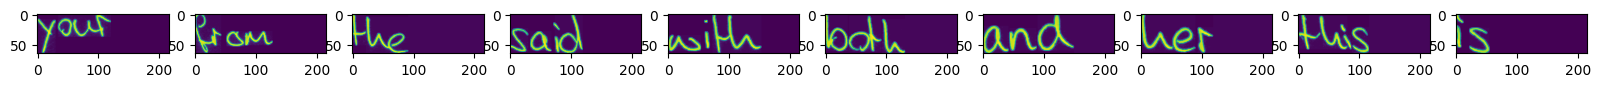

132
.\data\iam\words\train\c06\c06-091\c06-091-04-03.png


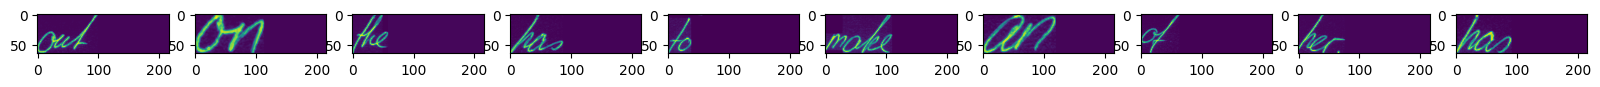

339
.\data\iam\words\train\g06\g06-047h\g06-047h-05-01.png


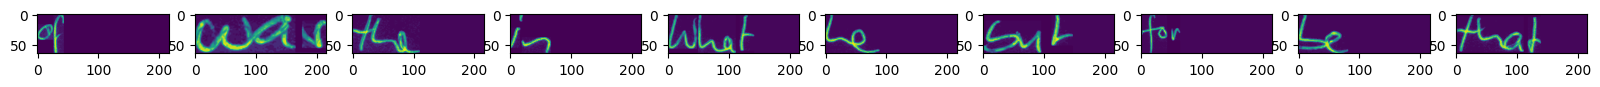

128
.\data\iam\words\train\b06\b06-071\b06-071-01-06.png


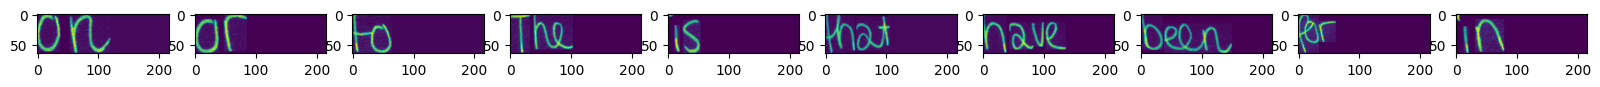

037
.\data\iam\words\train\a02\a02-106\a02-106-09-07.png


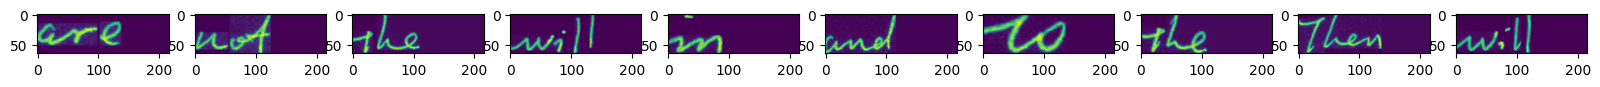

337
.\data\iam\words\train\g06\g06-047f\g06-047f-01-07.png


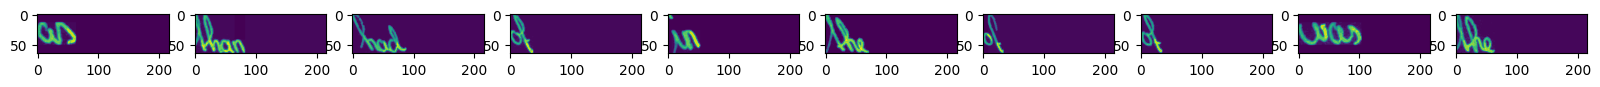

551
.\data\iam\words\train\n06\n06-182\n06-182-04-03.png


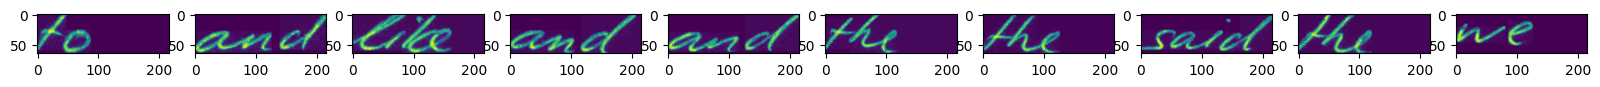

203
.\data\iam\words\train\e06\e06-010\e06-010-02-03.png


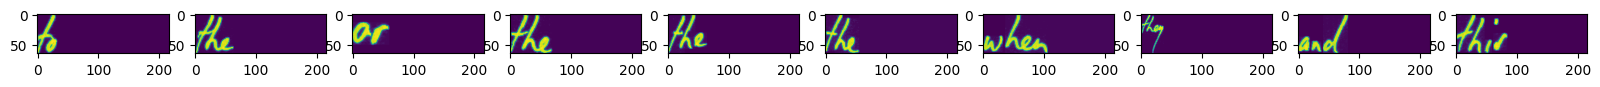

206
.\data\iam\words\train\e06\e06-000\e06-000-03-03.png


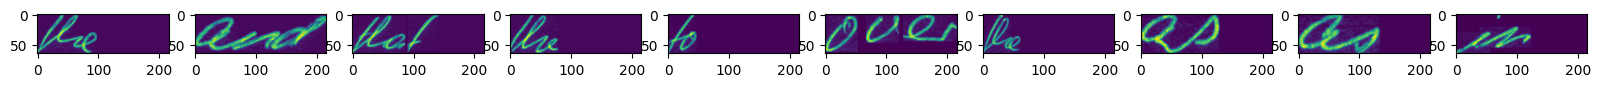

586
.\data\iam\words\train\n04\n04-190\n04-190-05-00.png


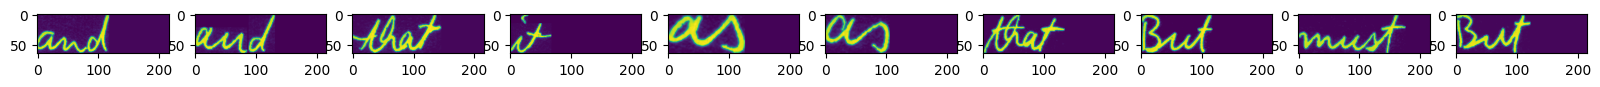

110
.\data\iam\words\train\b04\b04-089\b04-089-05-04.png


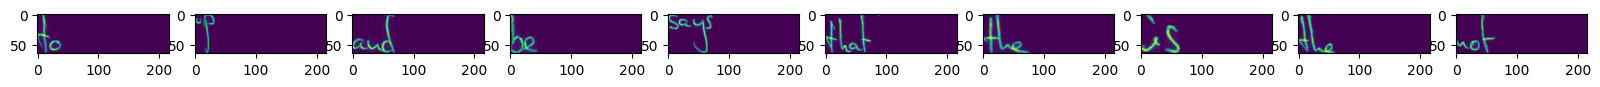

585
.\data\iam\words\train\n04\n04-156\n04-156-03-05.png


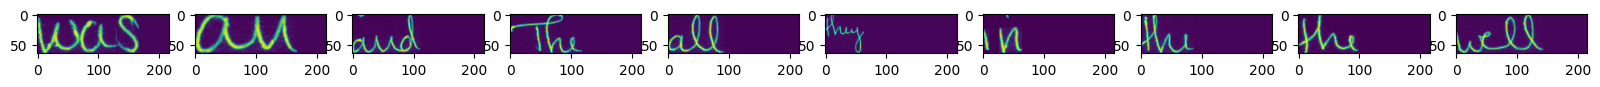

243
.\data\iam\words\train\e04\e04-124\e04-124-01-02.png


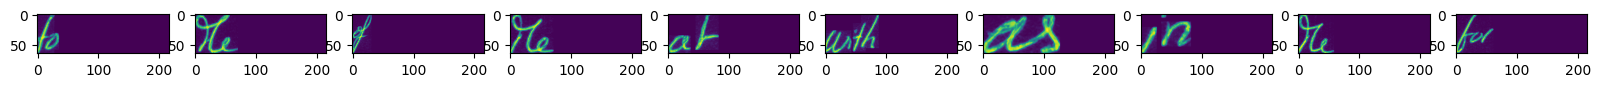

094
.\data\iam\words\train\b01\b01-132\b01-132-08-03.png


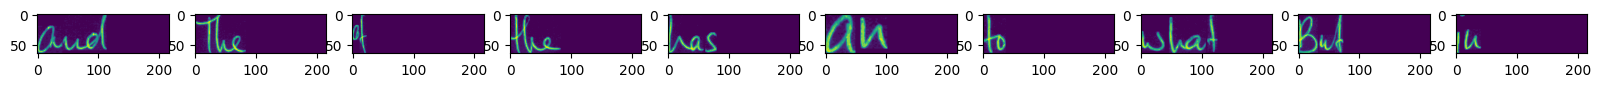

587
.\data\iam\words\train\n04\n04-218\n04-218-00-00.png


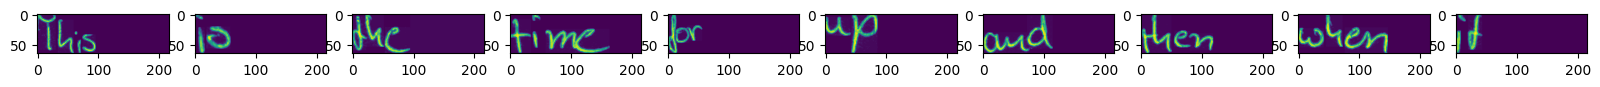

338
.\data\iam\words\train\g06\g06-018g\g06-018g-00-00.png


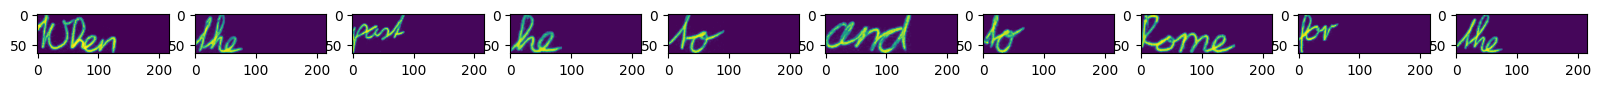

126
.\data\iam\words\train\b06\b06-110\b06-110-05-05.png


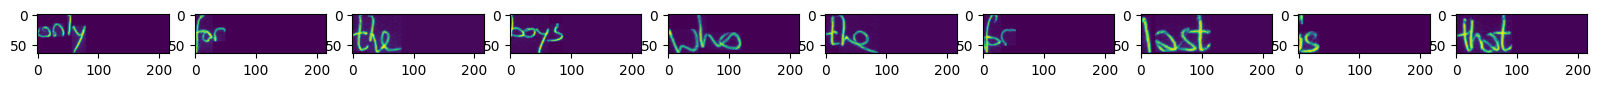

204
.\data\iam\words\train\e06\e06-015\e06-015-05-03.png


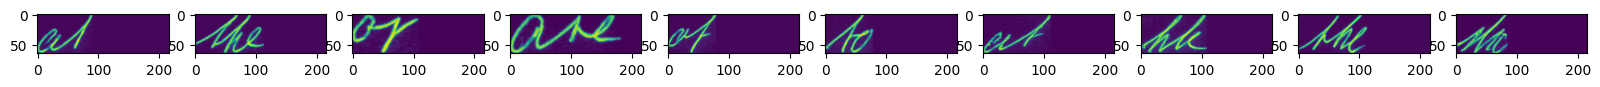

199
.\data\iam\words\train\d05\d05-025\d05-025-06-03.png


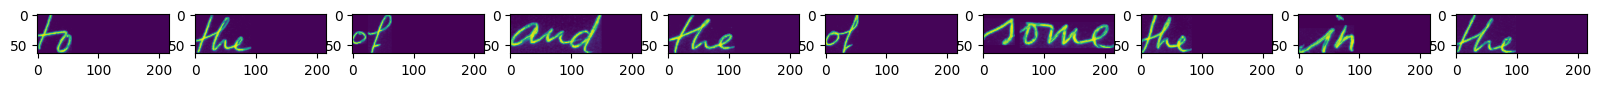

109
.\data\iam\words\train\b04\b04-054\b04-054-04-09.png


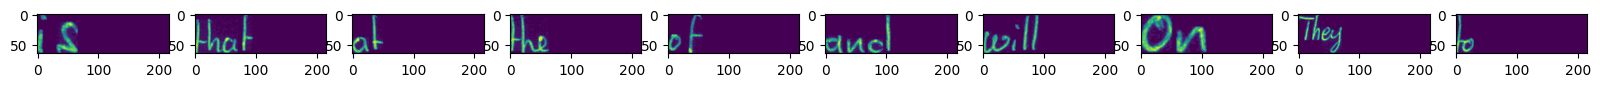

026
.\data\iam\words\train\a02\a02-090\a02-090-02-10.png


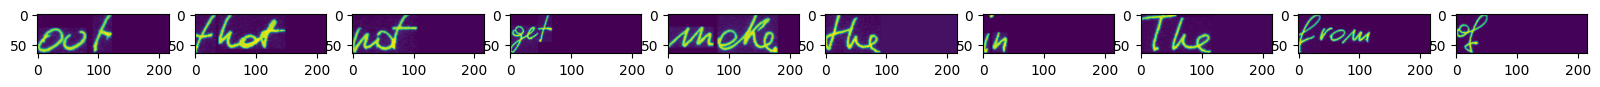

155
.\data\iam\words\train\c03\c03-081f\c03-081f-02-00.png


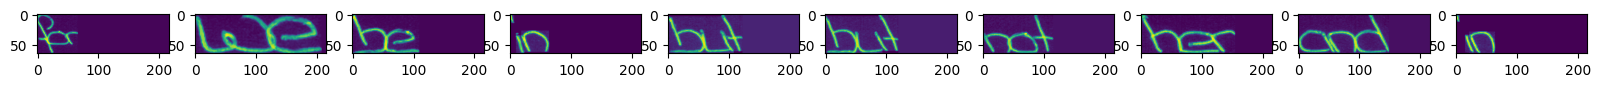

634
.\data\iam\words\train\p06\p06-088\p06-088-03-06.png


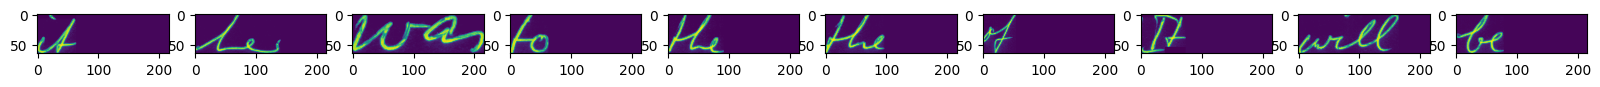

193
.\data\iam\words\train\f04\f04-096\f04-096-09-00.png


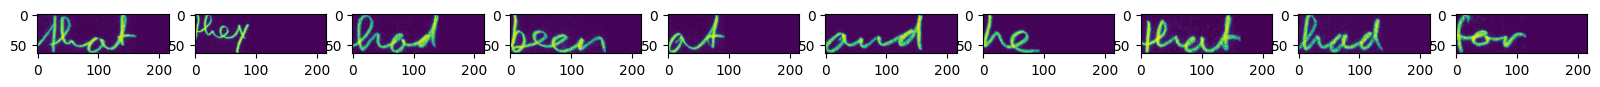

549
.\data\iam\words\train\m04\m04-216\m04-216-01-04.png


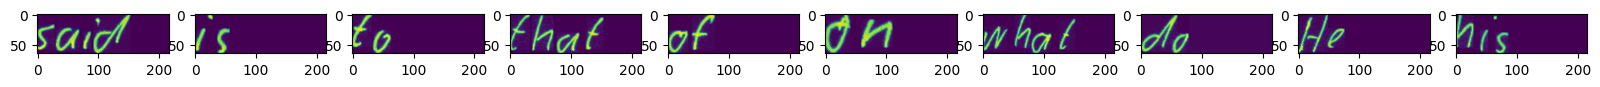

583
.\data\iam\words\train\n04\n04-068\n04-068-02-02.png


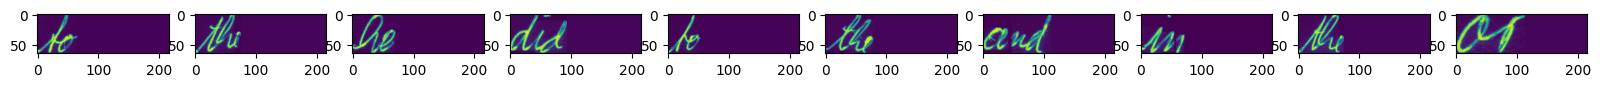

588
.\data\iam\words\train\n06\n06-123\n06-123-09-00.png


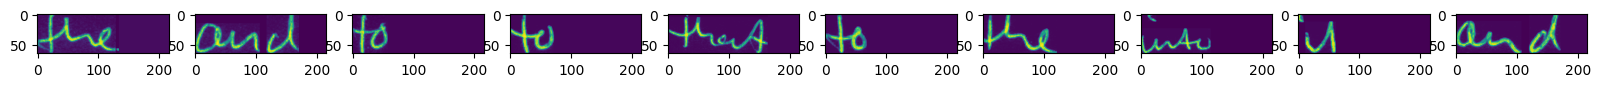

131
.\data\iam\words\train\c06\c06-095\c06-095-06-01.png


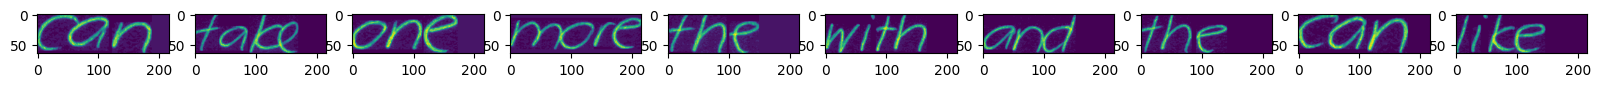

582
.\data\iam\words\train\n04\n04-039\n04-039-03-04.png


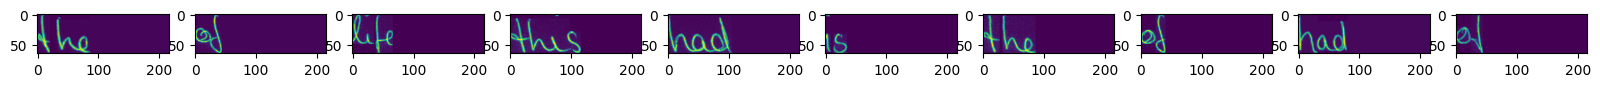

546
.\data\iam\words\train\m04\m04-093\m04-093-02-06.png


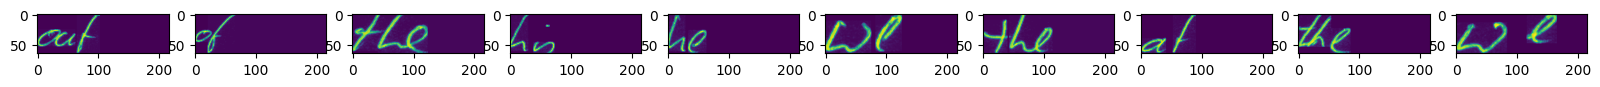

333
.\data\iam\words\train\g06\g06-047b\g06-047b-05-03.png


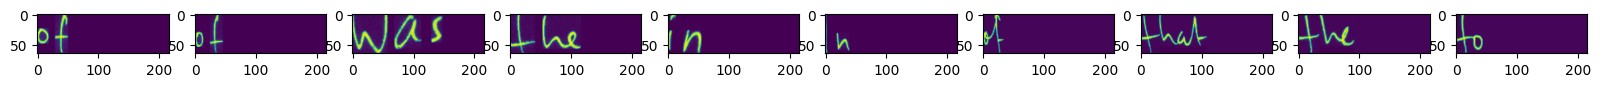

670
.\data\iam\words\train\r06\r06-066\r06-066-07-07.png


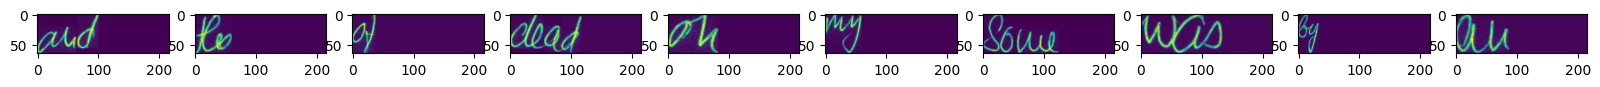

241
.\data\iam\words\train\e04\e04-091\e04-091-05-06.png


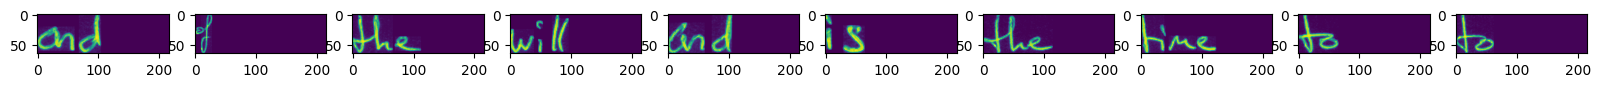

059
.\data\iam\words\train\a04\a04-019\a04-019-05-03.png


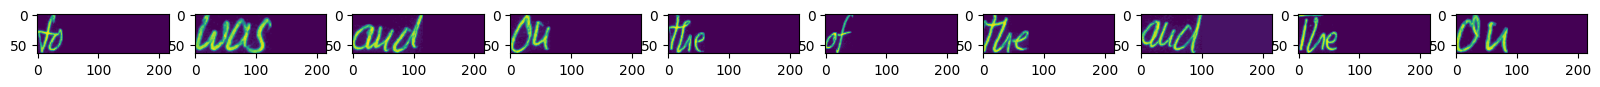

289
.\data\iam\words\train\f07\f07-039b\f07-039b-00-04.png


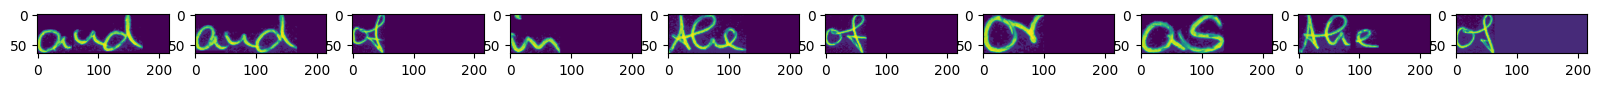

285
.\data\iam\words\train\f07\f07-046a\f07-046a-08-05.png


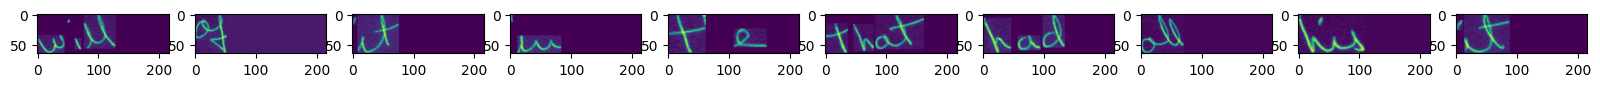

671
.\data\iam\words\train\r06\r06-111\r06-111-06-02.png


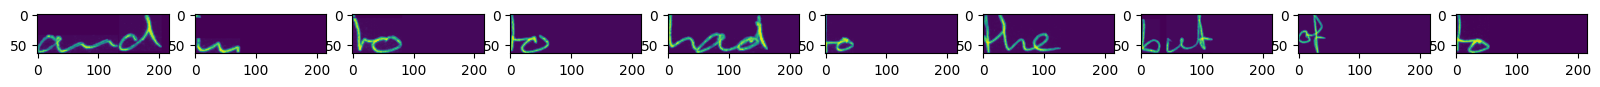

153
.\data\iam\words\train\c03\c03-081d\c03-081d-07-03.png


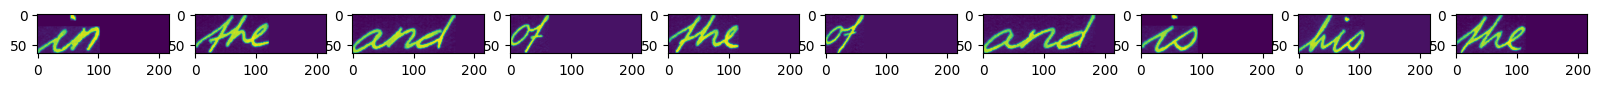

130
.\data\iam\words\train\c06\c06-000\c06-000-02-09.png


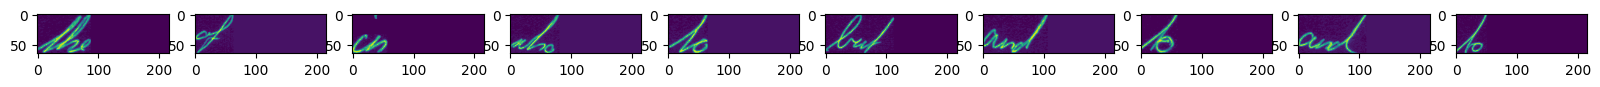

000
.\data\iam\words\train\a05\a05-104\a05-104-05-08.png


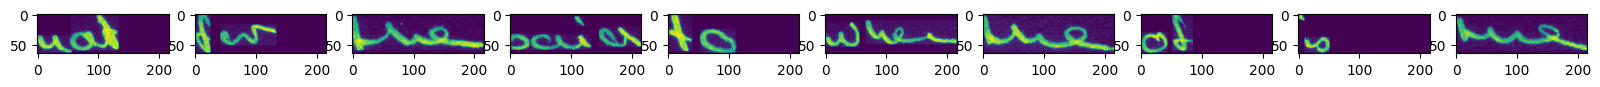

173
.\data\iam\words\train\d06\d06-046\d06-046-05-04.png


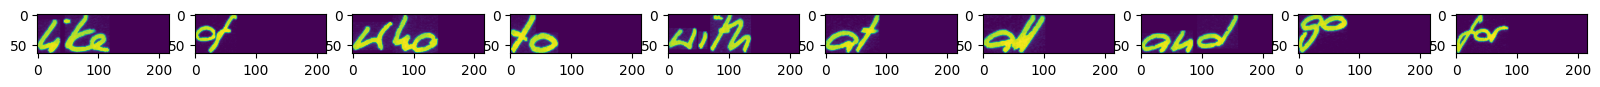

151
.\data\iam\words\train\c03\c03-096b\c03-096b-03-03.png


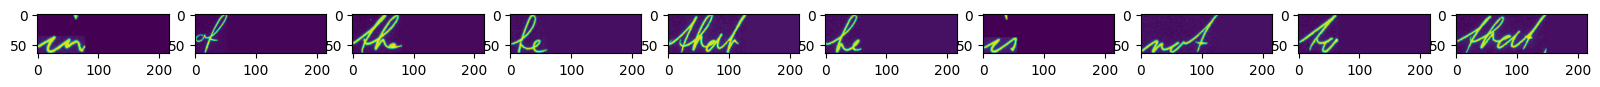

124
.\data\iam\words\train\b06\b06-075\b06-075-00-04.png


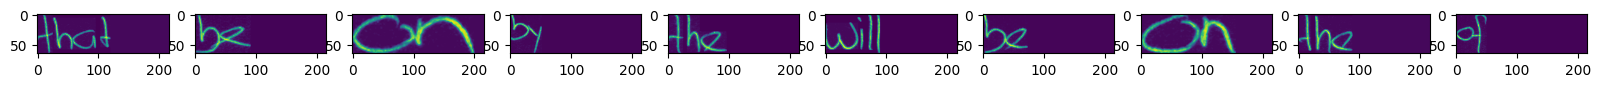

125
.\data\iam\words\train\c06\c06-020\c06-020-03-05.png


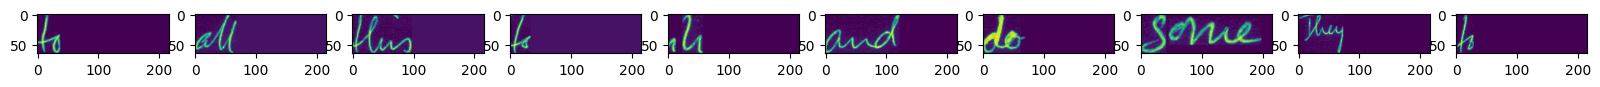

287
.\data\iam\words\train\f07\f07-021b\f07-021b-05-06.png


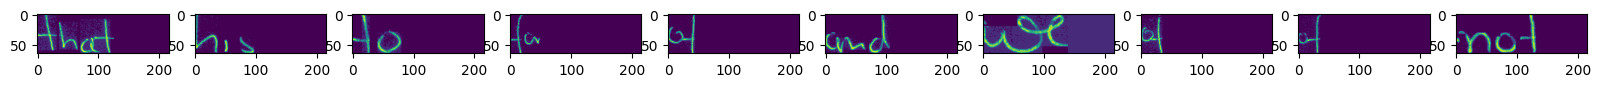

025
.\data\iam\words\train\a02\a02-024\a02-024-05-06.png


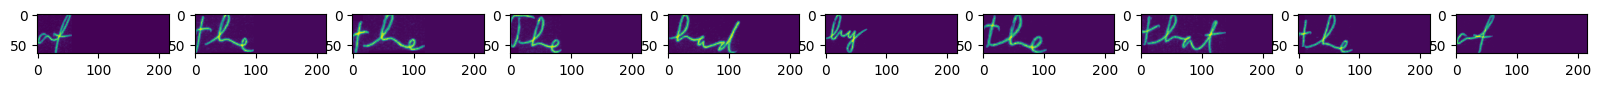

341
.\data\iam\words\train\g06\g06-011j\g06-011j-01-05.png


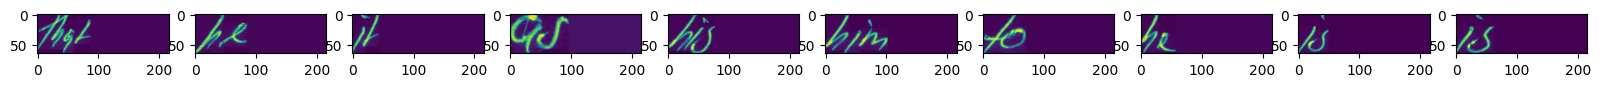

335
.\data\iam\words\train\g06\g06-042d\g06-042d-00-04.png


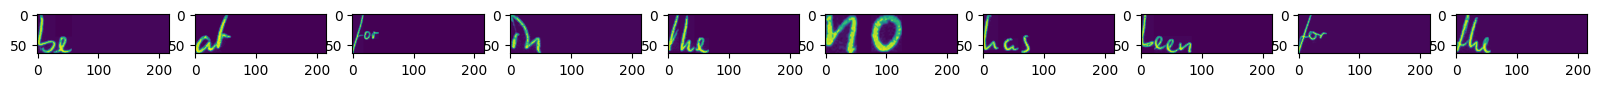

118
.\data\iam\words\train\g05\g05-098\g05-098-04-05.png


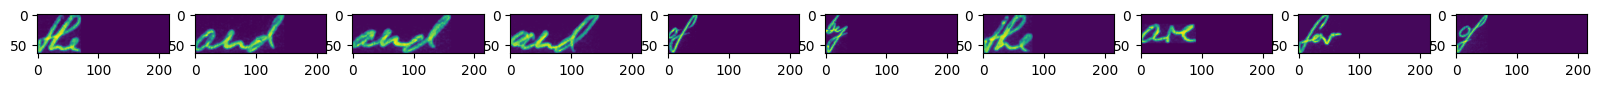

133
.\data\iam\words\train\c06\c06-043\c06-043-04-01.png


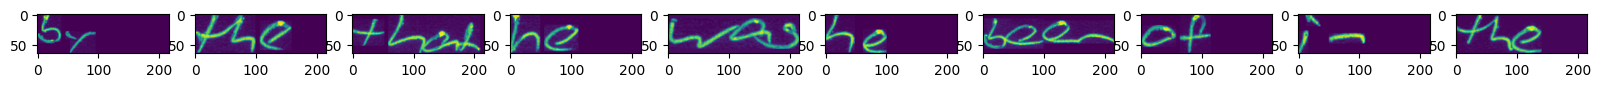

293
.\data\iam\words\train\f07\f07-101b\f07-101b-03-00.png


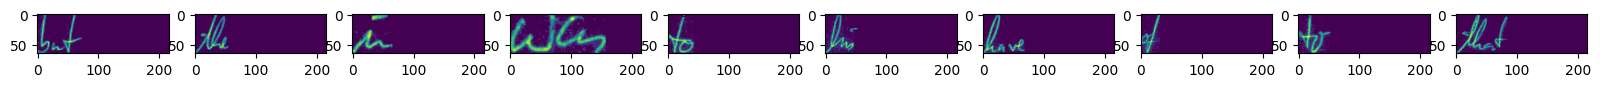

060
.\data\iam\words\train\a04\a04-039\a04-039-07-04.png


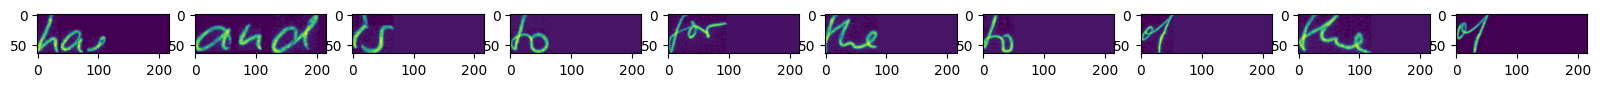

291
.\data\iam\words\train\f07\f07-081b\f07-081b-04-00.png


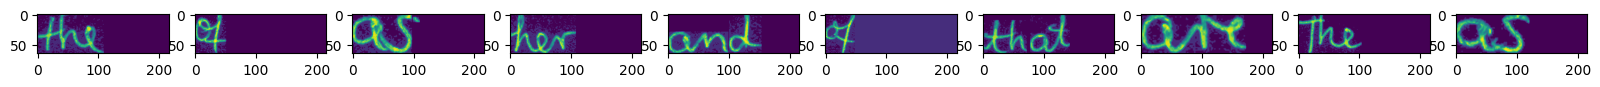

154
.\data\iam\words\train\c03\c03-096e\c03-096e-06-08.png


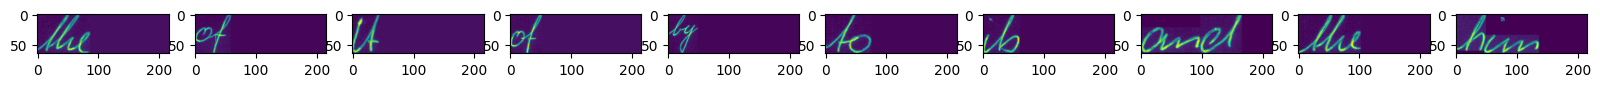

315
.\data\iam\words\train\n02\n02-127\n02-127-01-00.png


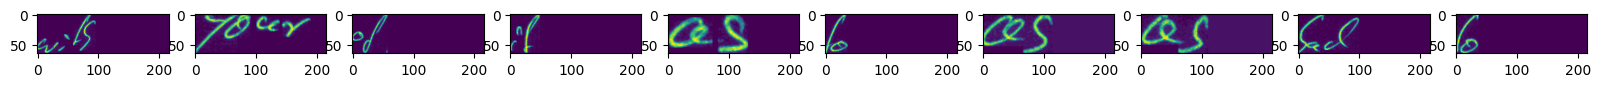

113
.\data\iam\words\train\b04\b04-181\b04-181-05-03.png


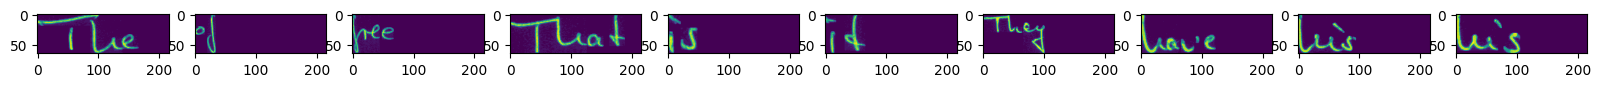

340
.\data\iam\words\train\g06\g06-031i\g06-031i-05-06.png


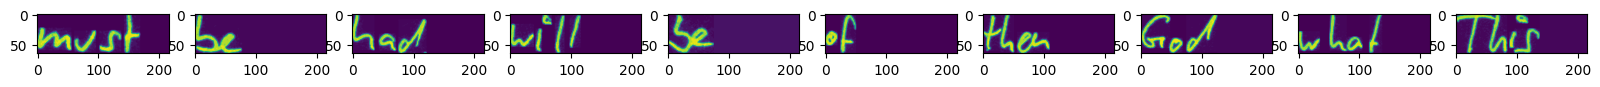

In [6]:
import matplotlib.pyplot as plt
for wid in set(wids_filtered):
    print(wid)
    print(filtered_wids[wid][1])

    plt.rcParams['figure.figsize'] = [20, 10]
    f, axarr = plt.subplots(1,10)
    

    for idx in range(1, 11):
        img = 255 - cv2.imread(filtered_wids[wid][idx], cv2.IMREAD_GRAYSCALE)
        img = transforms_(img)
        axarr[idx - 1].imshow(img[0])
    plt.show()

# wids for which 2-3 letter words fill up the entire image, and are therefore removed:
#


In [7]:
for word in set(words_filtered):
    print(word)

She
shot
when
has
for
rain
God
who
lead
many
one
Not
what
or
on
life
can
into
put
our
much
top
must
By
to
that
Some
so
Then
we
Sir
as
an
here
pity
two
the
last
off
base
When
play
more
net
In
with
its
held
she
may
from
But
take
no
They
and
my
The
had
are
past
made
be
free
work
than
whom
make
get
This
set
was
sent
will
by
some
of
day
What
do
this
just
One
in
Now
He
me
way
were
his
even
dead
her
not
then
him
us
your
old
all
both
said
So
did
is
been
town
if
he
them
over
And
bell
war
word
go
but
ever
year
time
says
any
it
boys
de
wet
like
see
That
most
well
To
only
long
We
out
come
they
am
told
Rome
have
man
food
up
It
at
you


In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, wids_train, _ = train_test_split(img_paths_filtered, wids_filtered, test_size=0.2, random_state=42, stratify=wids_filtered, shuffle=True)
print(len(X_test), len(X_train))
print(X_test[0], X_train[0])

os.makedirs('./subset/iam/words/train/', exist_ok=True)
os.makedirs('./subset/iam/words/test/',  exist_ok=True)

777 3105
('.\\data\\iam\\words\\train\\g06\\g06-011e\\g06-011e-06-11.png', 'by', '336') ('.\\data\\iam\\words\\train\\e06\\e06-041\\e06-041-02-02.png', 'it', '202')


In [9]:
test_dir = '.\\subset\\iam\\words\\test\\'
test_txt = '.\\subset\\iam\\words\\ground_truth_test.txt'

with open(test_txt, 'w') as f:

    for tup in X_test:
        img_path, gt_label, wid = tup[0], tup[1], tup[2]
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        img_name = img_path.split('\\')[-1]
        
        test_path = test_dir + img_name

        cv2.imwrite(test_path, img)
        f.write(f".{test_path} {gt_label} {wid}\n")


In [10]:
train_dir = ".\\subset\\iam\\words\\train\\"
train_txt = '.\\subset\\iam\\words\\ground_truth_train.txt'

import random
import imgaug.augmenters as iaa
RANDOM_STATE = 42
random.seed(RANDOM_STATE)

aug_seq = iaa.Sequential([
            iaa.Affine(scale=(0.9, 1.1), translate_px={"x": (0, 10), "y": (0, 5)}, random_state=RANDOM_STATE),
            iaa.Rotate((-10, 10), random_state=RANDOM_STATE),                 
            iaa.ShearX((-5, 5), random_state=RANDOM_STATE),                  
            iaa.ShearY((-5, 5), random_state=RANDOM_STATE)        
            ])

dil_kernel = np.ones((3, 3), np.uint8) 
er_kernel = np.ones((3, 3), np.uint8) 

with open(train_txt, 'w') as f:

    for tup in X_train:
        img_path, gt_label, wid = tup[0], tup[1], tup[2]
        img =  255 - cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        img_name = img_path.split('\\')[-1]
        
        train_path = train_dir + img_name

        cv2.imwrite(train_path, 255 - img)
        f.write(f".{train_path} {gt_label} {wid}\n")

        # plt.rcParams['figure.figsize'] = [20, 10]
        # fig, axarr = plt.subplots(1,6)
        # axarr[0].imshow(img)

        for idx in range(5):
            img_aug = img[:,:]
            if random.random() < 0.25:
                img_aug = cv2.erode(img_aug, er_kernel, iterations=1) 
            elif random.random() < 0.25:
                img_aug = cv2.dilate(img_aug, dil_kernel, iterations=1) 
            
            if random.random() < 0.25:
                img_aug = cv2.GaussianBlur(img_aug, (3, 3), 0)
            
            img_aug = aug_seq(images=[img_aug])
            aug_train_path = train_dir + f"aug_{idx}_"+ img_name
            cv2.imwrite(aug_train_path, 255 - img_aug[0])
            f.write(f".{aug_train_path} {gt_label} {wid}\n")

        #     axarr[idx + 1].imshow(img_aug[0])
        # plt.show()


In [12]:
from sklearn.model_selection import StratifiedKFold


skf = StratifiedKFold(n_splits=3, random_state=None, shuffle=True)
for i, (train_index, valid_index) in enumerate(skf.split(X_train, wids_train)):
    filename_train = f".\\subset\\iam\\words\\ground_truth_train-{i}.txt"
    filename_valid = f".\\subset\\iam\\words\\ground_truth_valid-{i}.txt"
    print("Starting fold ", i)
    train_split = [X_train[i] for i in train_index]
    valid_split = [X_train[i] for i in valid_index]

    with open(filename_train, 'w') as f_tr:
        for tup in train_split:
            img_path, gt_label, wid = tup[0], tup[1], tup[2]

            img_name = img_path.split('\\')[-1]
        
            train_path = train_dir + img_name

            f_tr.write(f".{train_path} {gt_label} {wid}\n")

            for idx in range(5):
                train_path = train_dir + f"aug_{idx}_" + img_name
                f_tr.write(f".{train_path} {gt_label} {wid}\n")
    
    with open(filename_valid, 'w') as f_tr:
        for tup in valid_split:
            img_path, gt_label, wid = tup[0], tup[1], tup[2]

            img_name = img_path.split('\\')[-1]
        
            train_path = train_dir + img_name

            f_tr.write(f".{train_path} {gt_label} {wid}\n")

Starting fold  0
Starting fold  1
Starting fold  2


### Recreating subset with synthetic images

In [2]:
def read_iam_subset(folder, max_word_len, n_fold):
    """Get data paths and labels (with max_word_len) of images in folder."""
    partitions = [f"train-{n_fold}", f"valid-{n_fold}", 'test']
    dataset = {}
    wid_dict = {}
    for partition in partitions:
        lens = {}
        print(partition)
        dataset[partition] = []

        text_file = os.path.join(folder, f"ground_truth_{partition}.txt")

        with open(text_file, encoding='utf-8') as data_file:
            lines = data_file.read().splitlines()

        for line in lines:
            line_split = line.split(' ')
            wid = None

            if not set(string.digits).isdisjoint(set(line_split[-1])):
                wid = line_split[-1]
                line_split = line_split[:-1]
                
            if len(line_split) > 2:
                img_path, gt_label = line_split[0], ''.join(line_split[1:])
            else:
                img_path, gt_label = line_split[0], line_split[1]
            
            if "aug" in img_path:
                continue
                
            if len(gt_label) > max_word_len:
                continue

            if len(gt_label) in lens.keys():
                lens[len(gt_label)] += 1
            else:
                lens[len(gt_label)] = 1
            
            img_path = img_path.replace("/", "\\")

            if wid is not None:
                if wid not in wid_dict.keys():
                    wid_dict[wid] = []
                
                if partition != "test":
                    wid_dict[wid].append((img_path, gt_label))

            # img_path = os.path.join(folder, partition, img_path)
            dataset[partition].append((img_path, gt_label, wid))
        print(f"number of words in {partition}: {len(dataset[partition])}")
        print(f"number of wids in {partition}: {len(wid_dict.keys())}")
    
        lens = dict(sorted(lens.items()))

        print(f"Number of words per word length")
        for key in lens.keys():
            print(key, lens[key])

    return dataset[f"train-{n_fold}"], dataset[f"valid-{n_fold}"], dataset['test'], wid_dict

In [3]:
train_0, valid_0, test, wid_dict = read_iam_subset(".\\subset\\iam\\words", 10, n_fold=0)
train_1, valid_1, test, wid_dict = read_iam_subset(".\\subset\\iam\\words", 10, n_fold=1)
train_2, valid_2, test, wid_dict = read_iam_subset(".\\subset\\iam\\words", 10, n_fold=2)

total_dataset = train_0[:]

for tup in valid_0:
    if tup not in total_dataset:
        total_dataset.append(tup)

print("Total number of samples:", len(total_dataset))

train-0
number of words in train-0: 2070
number of wids in train-0: 84
Number of words per word length
2 888
3 866
4 316
valid-0
number of words in valid-0: 1035
number of wids in valid-0: 84
Number of words per word length
2 470
3 421
4 144
test
number of words in test: 777
number of wids in test: 84
Number of words per word length
2 338
3 328
4 111
train-1
number of words in train-1: 2070
number of wids in train-1: 84
Number of words per word length
2 908
3 864
4 298
valid-1
number of words in valid-1: 1035
number of wids in valid-1: 84
Number of words per word length
2 450
3 423
4 162
test
number of words in test: 777
number of wids in test: 84
Number of words per word length
2 338
3 328
4 111
train-2
number of words in train-2: 2070
number of wids in train-2: 84
Number of words per word length
2 920
3 844
4 306
valid-2
number of words in valid-2: 1035
number of wids in valid-2: 84
Number of words per word length
2 438
3 443
4 154
test
number of words in test: 777
number of wids in 

In [36]:
def write_to_txt(file, data):
    with open(file, 'w') as f:
        for tup in data:
            img_path = tup[0].split('.png')[0]

            f.write(f"{img_path}_synth.png {tup[1]} {tup[2]}\n")
            

In [38]:
write_to_txt("./subset/iam/words/ground_truth_test_synth.txt", test)
write_to_txt("./subset/iam/words/ground_truth_valid-0_synth.txt", valid_0)
write_to_txt("./subset/iam/words/ground_truth_train-0_synth.txt", train_0)
write_to_txt("./subset/iam/words/ground_truth_valid-1_synth.txt", valid_1)
write_to_txt("./subset/iam/words/ground_truth_train-1_synth.txt", train_1)
write_to_txt("./subset/iam/words/ground_truth_valid-2_synth.txt", valid_2)
write_to_txt("./subset/iam/words/ground_truth_train-2_synth.txt", train_2)

In [4]:
charset_base = string.ascii_lowercase + string.ascii_uppercase
tokenizer = Tokenizer(chars=charset_base, max_text_length=25, self_supervised=True)

gen_model = GenModel_FC(tokenizer.maxlen, tokenizer.vocab_size, tokenizer.PAD)
# self.gen_model.load_state_dict(torch.load('./network/gen_model/gen_model-15all.model')) #load
gen_model.load_state_dict(torch.load('./src/network/gen_model/gen_model-25half.model'))
gen_model.eval()

for param in gen_model.parameters():
    param.requires_grad = False

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_size = (64, 216, 1)
num_style_imgs = 25 # num imgs for generator to extract style from
batch_size = 32
dataset = "iam"
dataset_path = os.path.join("..", "data", dataset, "words")
max_word_len = 10

In [6]:
data_train = RIMES_data(total_dataset, input_size=input_size, tokenizer=tokenizer, num_images=num_style_imgs, wids=wid_dict)
train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=1)

In [7]:
gen_model.to(device)

GenModel_FC(
  (enc_image): RecursiveScriptModule(
    original_name=ImageEncoder
    (model): RecursiveScriptModule(
      original_name=VGG
      (features): RecursiveScriptModule(
        original_name=Sequential
        (0): RecursiveScriptModule(original_name=Conv2d)
        (1): RecursiveScriptModule(original_name=InstanceNorm2d)
        (2): RecursiveScriptModule(original_name=ReLU)
        (3): RecursiveScriptModule(original_name=Conv2d)
        (4): RecursiveScriptModule(original_name=InstanceNorm2d)
        (5): RecursiveScriptModule(original_name=ReLU)
        (6): RecursiveScriptModule(original_name=Conv2d)
        (7): RecursiveScriptModule(original_name=InstanceNorm2d)
        (8): RecursiveScriptModule(original_name=ReLU)
        (9): RecursiveScriptModule(original_name=Conv2d)
        (10): RecursiveScriptModule(original_name=InstanceNorm2d)
        (11): RecursiveScriptModule(original_name=ReLU)
        (12): RecursiveScriptModule(original_name=MaxPool2d)
        (13):

In [30]:
import matplotlib.pyplot as plt
for batch in train_loader:
    imgs, gen_imgs, gt_labels, _, img_path = batch
    gt_labels = torch.nn.functional.one_hot(gt_labels.long(), 56).float()

    imgs = imgs.to(device)
    gen_imgs = gen_imgs.to(device).squeeze(2)
    gt_labels = gt_labels.to(device)

    synth_imgs = gen_model(gen_imgs, gt_labels)

    synth_imgs = synth_imgs.squeeze(1).cpu().numpy()
    # print(synth_imgs.shape)

    # plt.imshow(synth_imgs[0])
    # plt.show()

    for idx, synth_img in enumerate(synth_imgs):
        new_path = img_path[idx].split(".png")[0]
        cv2.imwrite(new_path[1:] + '_synth.png', 255 - ((synth_img * 0.5) + 0.5) * 255)


In [31]:
data_test = RIMES_data(test, input_size=input_size, tokenizer=tokenizer, num_images=num_style_imgs, wids=wid_dict)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=1)

In [32]:
import matplotlib.pyplot as plt
for batch in test_loader:
    imgs, gen_imgs, gt_labels, _, img_path = batch
    gt_labels = torch.nn.functional.one_hot(gt_labels.long(), 56).float()

    imgs = imgs.to(device)
    gen_imgs = gen_imgs.to(device).squeeze(2)
    gt_labels = gt_labels.to(device)

    synth_imgs = gen_model(gen_imgs, gt_labels)

    synth_imgs = synth_imgs.squeeze(1).cpu().numpy()
    # print(synth_imgs.shape)

    # plt.imshow(synth_imgs[0])
    # plt.show()

    for idx, synth_img in enumerate(synth_imgs):
        new_path = img_path[idx].split(".png")[0]
        cv2.imwrite(new_path[1:] + '_synth.png', 255 - ((synth_img * 0.5) + 0.5) * 255)